# Centrality measures

In [1]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import networkx as nx
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

#Prepare the network plot for animation
import plotly.graph_objects as go

from utils import weight, create_edges, create_nodes_weight

In [2]:
#Save the graph locations and week number in a list
mypath = '../raccoon_proximity_weighted'
files = [mypath + '/' + f for f in listdir(mypath) if isfile(join(mypath, f))]
files = [(int(f.split('_')[5].split('.')[0]), f) for f in files]
files.sort()

In [3]:
#Build a dataframe with only the first 16 raccoons in each week
df = pd.DataFrame()
filt = [str(x) for x in range(16)]

def weight(G, node):
    """Calculates the total of interaction of a single raccoon
    
    Input:  Graph object G
            Raccoon_ID node
           
    Output: Corrected log(s + 1) of interaction"""
    s = 0
    for g in G[node]:
        if g in filt:
            s += G[node][g]['weight']
    return np.log(s + 1)

int_deg = {'week':[], 'int_deg':[]}
diam = {'week':[], 'diameter':[]}

for f in files:
    #Read the graph and calculate node degrees
    G = nx.read_graphml(f[1]).subgraph(filt)
    deg = pd.DataFrame({'week':f[0], 'raccoon_ID':list(G), 'degree':list(dict(G.degree).values())})
    
    #Calculate degree vs. interaction
    for n in G.nodes():
        int_deg['week'].append(f[0])
        int_deg['int_deg'].append(weight(G, n)/G.degree[n])
        
    #Diameter
    diam['week'].append(f[0])
    if nx.is_connected(G):
        diam['diameter'].append(nx.diameter(G))
    else:
        d = 0
        for g in nx.connected_components(G):
            d = d + nx.diameter(G.subgraph(g))*len(G.subgraph(g))/len(G)
        diam['diameter'].append(d)
    
    
    #Calculate inverse log interaction
    invlogint = {}
    logint = {}
    for e in list(G.edges.data()):
        invlogint[(e[0], e[1])] = 1/(1 + np.log(1 + e[2]['weight']))
        logint[(e[0], e[1])] = np.log( 1 + e[2]['weight'])

    nx.set_edge_attributes(G, logint, 'log_interaction')
    nx.set_edge_attributes(G, invlogint, 'inverse_log_interaction')
    
    #Degree centrality
    DC = nx.degree_centrality(G)
    DC = pd.DataFrame({'week':f[0], 'raccoon_ID':list(DC.keys()),
                           'deg_cent':list(DC.values())})
    
    #Betweenness centrality
    BC = nx.betweenness_centrality(G, weight='log_interaction')
    BC = pd.DataFrame({'week':f[0], 'raccoon_ID':list(BC.keys()),
                           'bet_cent':list(BC.values())})
    
    #Closeness centrality
    CC = nx.closeness_centrality(G, distance='inverse_log_interaction')
    CC = pd.DataFrame({'week':f[0], 'raccoon_ID':list(CC.keys()),
                           'clos_cent':list(CC.values())})
    
    #Eigenvector centrality
    EC = nx.eigenvector_centrality(G, weight='log_interaction', max_iter=1000)
    EC = pd.DataFrame({'week':f[0], 'raccoon_ID':list(EC.keys()),
                           'eig_cent':list(EC.values())})
    
    #Build the dataframe
    df_aux = DC.merge(BC, how='outer', on=['week', 'raccoon_ID'])
    df_aux = df_aux.merge(CC, how='outer', on=['week', 'raccoon_ID'])
    df_aux = df_aux.merge(EC, how='outer', on=['week', 'raccoon_ID'])
    df_aux = df_aux.merge(deg, how='outer', on=['week', 'raccoon_ID'])
    df = pd.concat([df,df_aux])
    
#Show the final dataframe
df['raccoon_ID'] = pd.to_numeric(df['raccoon_ID'])
df

<ipython-input-3-c615aacdab5a>:29: RuntimeWarning:

invalid value encountered in double_scalars



week  raccoon_ID  deg_cent  bet_cent  clos_cent  eig_cent  degree
0      1           1  0.142857  0.000000   1.803323  0.058769       2
1      1           2  0.285714  0.076923   2.092258  0.119731       4
2      1           3  0.428571  0.263736   2.633417  0.277635       6
3      1           4  0.071429  0.000000   1.213827  0.007809       1
4      1           5  0.071429  0.000000   1.219384  0.014888       1
..   ...         ...       ...       ...        ...       ...     ...
11    52          11  0.133333  0.095238   2.108436  0.048631       2
12    52          12  0.133333  0.000000   2.906450  0.238116       2
13    52          13  0.133333  0.000000   2.410722  0.109691       2
14    52          14  0.400000  0.076190   3.638798  0.324601       6
15    52          15  0.200000  0.076190   2.429599  0.105413       3

[730 rows x 7 columns]

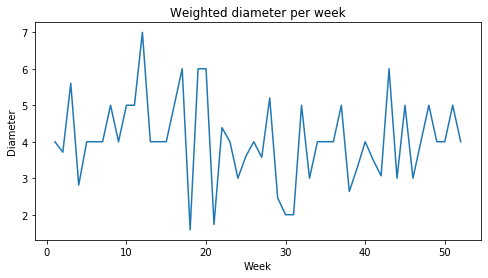

In [4]:
fig, ax =plt.subplots(1,1, figsize=(8, 4))
sns.lineplot(diam['week'], diam['diameter'])
ax.set_title("Weighted diameter per week")
ax.grid(False)
ax.set_ylabel('Diameter')    
ax.set_xlabel('Week');

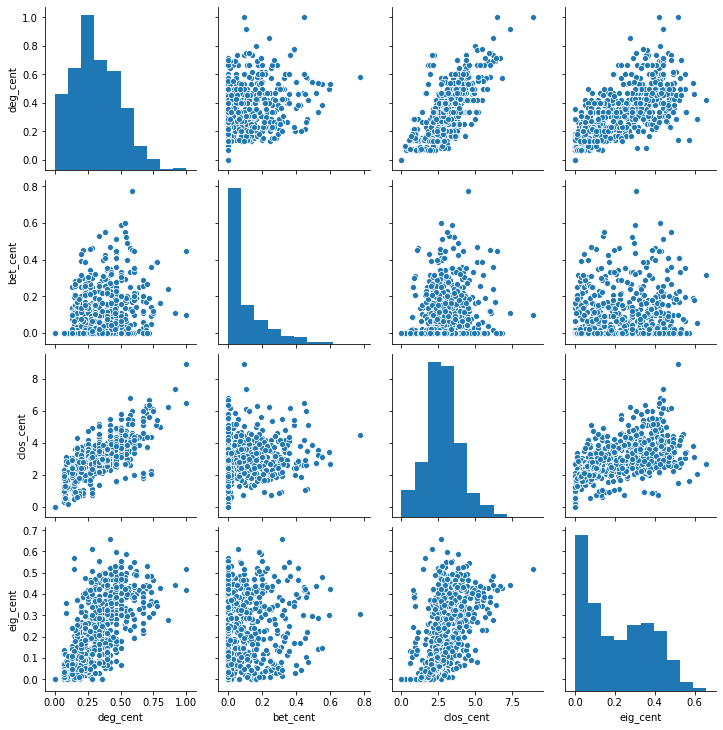

In [5]:
sns.pairplot(df.drop(['week', 'raccoon_ID', 'degree'], axis=1));

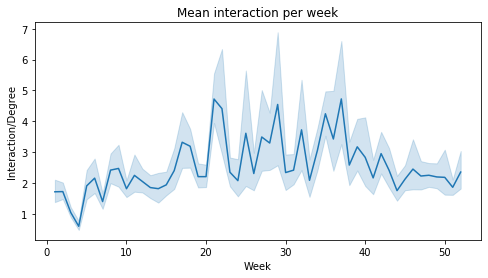

In [6]:
fig, ax =plt.subplots(1,1, figsize=(8, 4))
sns.lineplot(int_deg['week'], int_deg['int_deg'])
ax.set_title("Mean interaction per week")
ax.grid(False)
ax.set_ylabel('Interaction/Degree')    
ax.set_xlabel('Week');

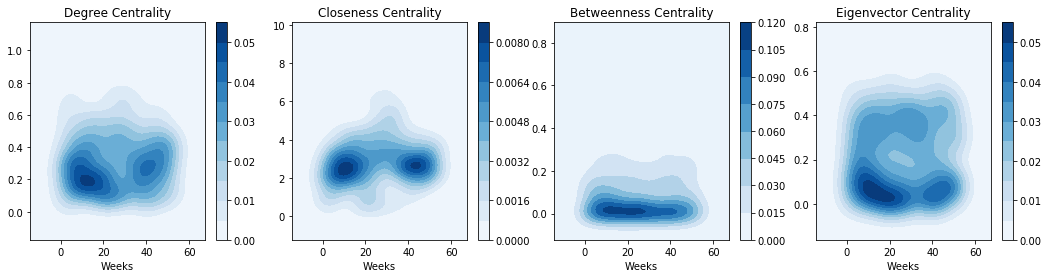

In [7]:
fig, ax =plt.subplots(1,4, figsize=(18, 4))
sns.kdeplot(df['week'], df['deg_cent'], cmap="Blues", shade=True, shade_lowest=True, ax=ax[0], cbar=True)
sns.kdeplot(df['week'], df['clos_cent'], cmap="Blues", shade=True, shade_lowest=True, ax=ax[1], cbar=True)
sns.kdeplot(df['week'], df['bet_cent'], cmap="Blues", shade=True, shade_lowest=True, ax=ax[2], cbar=True)
sns.kdeplot(df['week'], df['eig_cent'], cmap="Blues", shade=True, shade_lowest=True, ax=ax[3], cbar=True)
titles = ["Degree Centrality", "Closeness Centrality", "Betweenness Centrality", "Eigenvector Centrality"]
for i in range(len(ax)):
    ax[i].set_title(titles[i])
    ax[i].set_ylabel('')    
    ax[i].set_xlabel('Weeks')

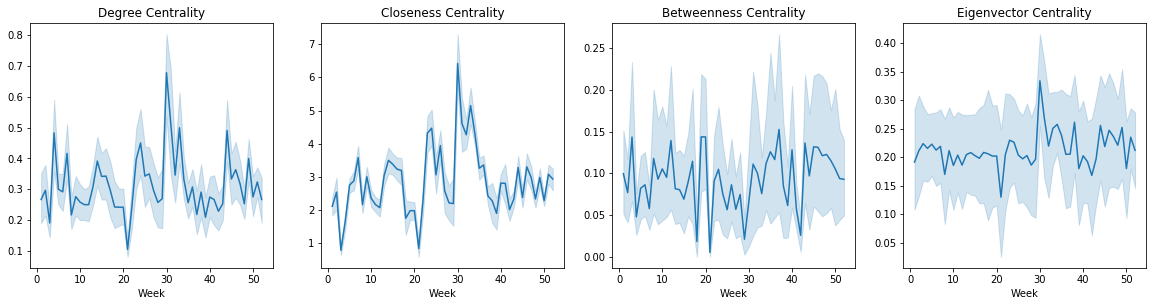

In [8]:
fig, ax =plt.subplots(1,4, figsize=(20, 4.5))
sns.lineplot(df['week'], df['deg_cent'], ax=ax[0])
sns.lineplot(df['week'], df['clos_cent'], ax=ax[1])
sns.lineplot(df['week'], df['bet_cent'], ax=ax[2])
sns.lineplot(df['week'], df['eig_cent'], ax=ax[3])
titles = ["Degree Centrality", "Closeness Centrality", "Betweenness Centrality", "Eigenvector Centrality"]
for i in range(len(ax)):
    ax[i].set_title(titles[i])
    ax[i].grid(False)
    ax[i].set_ylabel('')    
    ax[i].set_xlabel('Week')

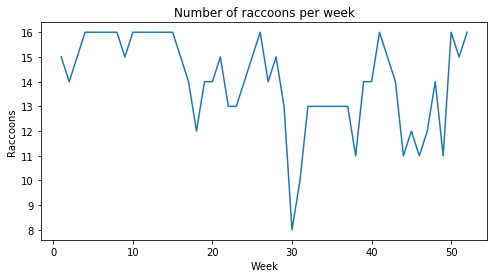

In [9]:
gweek = df.groupby('week').count()['raccoon_ID']
fig, ax =plt.subplots(1,1, figsize=(8, 4))
sns.lineplot(gweek.index, gweek.values, ax=ax)
ax.set_title("Number of raccoons per week")
ax.grid(False)
ax.set_ylabel('Raccoons')    
ax.set_xlabel('Week');

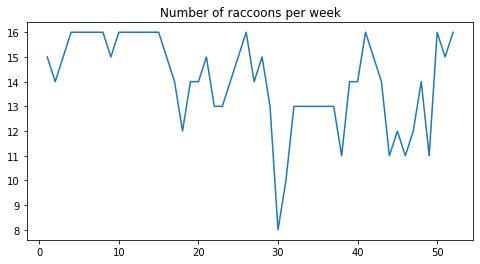

In [10]:
fig, ax =plt.subplots(1,1, figsize=(8, 4))
sns.lineplot(gweek.index, gweek.values, ax=ax)
ax.set_title("Number of raccoons per week")
ax.grid(False)
ax.set_ylabel('')    
ax.set_xlabel('');

In [11]:
#Plot mean centralities by raccoon
mean_by_id = df.drop('week', axis=1).groupby('raccoon_ID').mean().reset_index()
for col in mean_by_id.drop('raccoon_ID', axis=1).columns:
    mx = max(mean_by_id[col])
    mean_by_id[col] = mean_by_id[col]/mx
mean_by_id = mean_by_id.drop('degree', axis=1).melt('raccoon_ID')
px.bar(mean_by_id, x="raccoon_ID", y='value', title='Normalized Node Centrality by Raccoon',
       color='variable').show()

In [12]:
#Plot mean centralities by week
mean_by_week = df.drop('raccoon_ID', axis=1).groupby('week').mean().reset_index()
for col in mean_by_week.drop(['week', 'degree'], axis=1).columns:
    mn = min(mean_by_week[col])
    mx = max(mean_by_week[col])
    mean_by_week[col] = (mean_by_week[col] - mn)/(mx - mn)
mean_by_week = mean_by_week.melt('week')
px.line(mean_by_week[mean_by_week.variable!='degree'], x='week', y='value', color='variable',
        title='Normalized Mean Node Centrality by Week', line_shape='spline').show()
px.line(mean_by_week[mean_by_week.variable=='degree'], x='week', y='value', color='variable',
        title='Mean Node Degree by Week', line_shape='spline').show()

In [13]:
#Plot max centralities by week
max_by_week = df.drop('raccoon_ID', axis=1).groupby('week').max().reset_index()
for col in max_by_week.drop(['week', 'degree'], axis=1).columns:
    mn = min(max_by_week[col])
    mx = max(max_by_week[col])
    max_by_week[col] = (max_by_week[col] - mn)/(mx - mn)
max_by_week = max_by_week.melt('week')
px.line(max_by_week[max_by_week.variable!='degree'], x='week', y='value', color='variable',
        title='Normalized Max Node Centrality by Week', line_shape='spline').show()
px.line(max_by_week[max_by_week.variable=='degree'], x='week', y='value', color='variable',
        title='Max Node Degree by Week', line_shape='spline').show()

In [14]:
#Plot min centralities by week
min_by_week = df.drop('raccoon_ID', axis=1).groupby('week').min().reset_index()
for col in min_by_week.drop(['week', 'degree'], axis=1).columns:
    mn = min(min_by_week[col])
    mx = max(min_by_week[col])
    min_by_week[col] = (min_by_week[col] - mn)/(mx - mn)
min_by_week = min_by_week.melt('week')
px.line(min_by_week[min_by_week.variable!='degree'], x='week', y='value', color='variable',
        title='Normalized Min Node Centrality by Week', line_shape='spline').show()
px.line(min_by_week[min_by_week.variable=='degree'], x='week', y='value', color='variable',
        title='Min Node Degree by Week', line_shape='spline').show()

In [15]:
#Create a position dictionary for all weeks
final_pos = pd.DataFrame()
for f in files:
    g = nx.read_graphml(f[1]).subgraph(filt)
    final_pos = pd.concat([final_pos, pd.DataFrame(nx.spring_layout(g)).transpose()])

#final_pos.reset_index().groupby('index').mean().to_csv('final_pos.csv')

In [16]:
#Read the position dictionary from a csv
final_pos = pd.read_csv('final_pos.csv', index_col='index')
final_pos.index = final_pos.index.map(str)
final_pos = dict(final_pos.apply(lambda x: np.array([x[0], x[1]]), axis=1))

# Animation

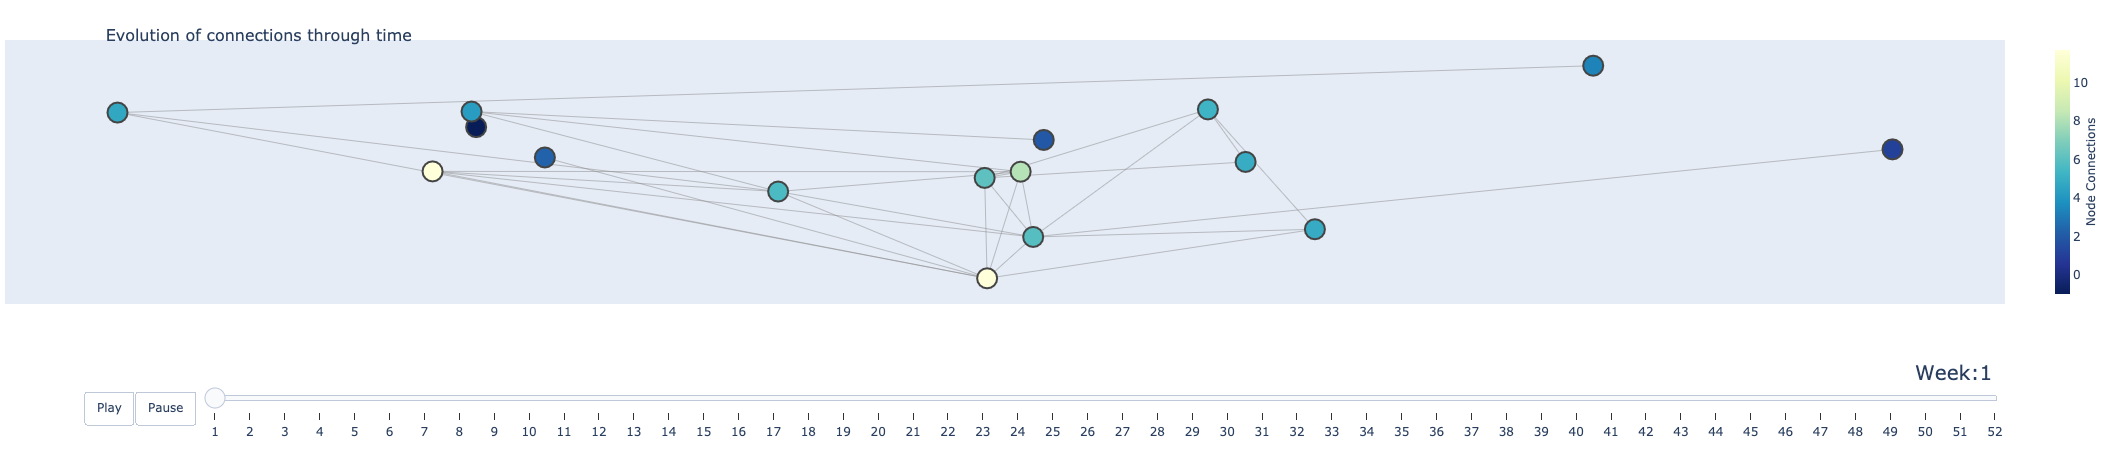

In [19]:
#Create the animation
weeks = df['week'].unique()

# make figure
G = nx.read_graphml(files[0][1]).subgraph(filt)
fig_dict = {
    "data": [create_edges(G, final_pos), create_nodes_weight(G, final_pos)],
    "layout": {},
    "frames": []
}

# fill in most of layout
fig_dict["layout"]['title'] = '<br>Evolution of connections through time'
fig_dict["layout"]['titlefont_size'] = 16
fig_dict["layout"]['showlegend'] = False
fig_dict["layout"]['hovermode'] = 'closest'
fig_dict["layout"]['margin'] = dict(b=20,l=5,r=5,t=40)
fig_dict["layout"]['xaxis'] = dict(showgrid=False, zeroline=False, showticklabels=False)
fig_dict["layout"]['yaxis'] = dict(showgrid=False, zeroline=False, showticklabels=False)

fig_dict["layout"]["sliders"] = {
    "args": [
        "transition", {
            "duration": 400,
            "easing": "cubic-in-out"
        }
    ],
    "initialValue": "1",
    "plotlycommand": "animate",
    "values": weeks,
    "visible": True
}
fig_dict["layout"]["updatemenus"] = [
    {
        "buttons": [
            {
                "args": [None, {"frame": {"duration": 1000, "redraw": False},
                                "fromcurrent": True, "transition": {"duration": 300,
                                                                    "easing": "quadratic-in-out"}}],
                "label": "Play",
                "method": "animate"
            },
            {
                "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                  "mode": "immediate",
                                  "transition": {"duration": 0}}],
                "label": "Pause",
                "method": "animate"
            }
        ],
        "direction": "left",
        "pad": {"r": 10, "t": 87},
        "showactive": False,
        "type": "buttons",
        "x": 0.1,
        "xanchor": "right",
        "y": 0,
        "yanchor": "top"
    }
]

sliders_dict = {
    "active": 0,
    "yanchor": "top",
    "xanchor": "left",
    "currentvalue": {
        "font": {"size": 20},
        "prefix": "Week:",
        "visible": True,
        "xanchor": "right"
    },
    "transition": {"duration": 300, "easing": "cubic-in-out"},
    "pad": {"b": 10, "t": 50},
    "len": 0.9,
    "x": 0.1,
    "y": 0,
    "steps": []
}

#Update the data and frames

for f in files:
    G = nx.read_graphml(f[1]).subgraph(filt)
    frame = {"data": [create_edges(G, final_pos), create_nodes_weight(G, final_pos)], "name": f[0]}
    fig_dict["frames"].append(frame)
    slider_step = {"args": [
        [f[0]],
        {"frame": {"duration": 300, "redraw": False},
         "mode": "immediate",
         "transition": {"duration": 300}}
    ],
        "label": f[0],
        "method": "animate"}
    sliders_dict["steps"].append(slider_step)
    
fig_dict["layout"]["sliders"] = [sliders_dict]

fig = go.Figure(fig_dict)

fig.show()